In [ ]:
!pip install segmentation-models albumentations

In [19]:
%load_ext autoreload
%autoreload 2

# include include folder
import sys
sys.path.append("./miniaturautonomie_lanedetection/include/")
sys.path.append("./include/")

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import os
import fnmatch
import random
import cv2
import json

import supervisely_parser as svp
import grid_parser as gp
from DataGenerator import DataGenerator

import albumentations as Alb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
annotation_path = './annotation_v3.0/'
image_path = './data/'
packages = ['knuff_main1', 'knuff_main2', 'knuff_main3', 'knuff_hill', 'uni', 'highway', 'knuff_main5', 'knuff_main6']

model_path = './model/ld_autosys.h5'

number_classes = 7 # outer, middle_curb, guide_lane, solid_lane, hold_line, zebra, background
output_width = 640 
output_height = 224 
input_width = 640 
input_height = 240

val_size = 0.2 # percentage
augmentation = True

batch_size = 16
epochs = 5

transform = Alb.Compose([
    Alb.ShiftScaleRotate(p=1.0),
    Alb.RandomContrast(p=0.9),
    Alb.RandomBrightness(limit=[-0.4,0.2], p=0.8)
])

params = {
    'batch_size': batch_size,
    'input_img_size': (480, 640),
    'target_img_size': (output_height, output_width),
    'shuffle': True,
    'n_channels': number_classes,
    'transform': transform
}

# generate absolute list of all img and ann paths
image_paths = []
ann_paths = []
# for package
for index in range(len(packages)):
    image_base_path = f"{image_path}{packages[index]}/"
    annotation_base_path = f"{annotation_path}{packages[index]}/ann/"

    file_list = os.listdir(annotation_base_path)
    pattern = '*.json'
    for filename in file_list:
        if fnmatch.fnmatch(filename, pattern):
            ann_paths.append(os.path.join(annotation_base_path, filename))
            image_name = os.path.splitext(filename)[0]
            image_paths.append(os.path.join(image_base_path, image_name))

            if augmentation:
                ann_paths.append(os.path.join(annotation_base_path, filename))
                image_paths.append(os.path.join(image_base_path, f"{image_name}.aug"))


# split into train and val set
size_all = len(image_paths)
val_samples = int(size_all*val_size)
random.Random(size_all).shuffle(image_paths)
random.Random(size_all).shuffle(ann_paths)

train_input_img_paths = image_paths[:-val_samples]
train_target_ann_paths = ann_paths[:-val_samples]
val_input_img_paths = image_paths[-val_samples:]
val_target_ann_paths = ann_paths[-val_samples:]

print(f"Len train img: {len(train_input_img_paths)} len train ann: {len(train_target_ann_paths)}")
print(f"Len val img: {len(val_input_img_paths)} len val ann: {len(val_target_ann_paths)}")

# Generators
train_gen = DataGenerator(train_input_img_paths, train_target_ann_paths, **params)
val_gen = DataGenerator(val_input_img_paths, val_target_ann_paths, **params)

    

Len train img: 1216 len train ann: 1216
Len val img: 304 len val ann: 304


image read took: 2.7589797973632812ms
rendering took: 12.873649597167969ms
image read took: 2.7954578399658203ms
rendering took: 11.47603988647461ms
image read took: 2.7303695678710938ms
rendering took: 3.9043426513671875ms
image read took: 2.749919891357422ms
rendering took: 4.365205764770508ms
image read took: 2.644062042236328ms
rendering took: 3.8270950317382812ms
image read took: 3.271341323852539ms
rendering took: 12.947797775268555ms
image read took: 3.0388832092285156ms
rendering took: 13.792037963867188ms
image read took: 3.251791000366211ms
rendering took: 12.06207275390625ms
image read took: 2.8443336486816406ms
rendering took: 9.906768798828125ms
image read took: 2.9027462005615234ms
rendering took: 11.305093765258789ms
image read took: 3.0460357666015625ms
rendering took: 4.050016403198242ms
image read took: 3.075122833251953ms
rendering took: 11.98124885559082ms
image read took: 2.972126007080078ms
rendering took: 3.9517879486083984ms
image read took: 2.9566287994384766ms

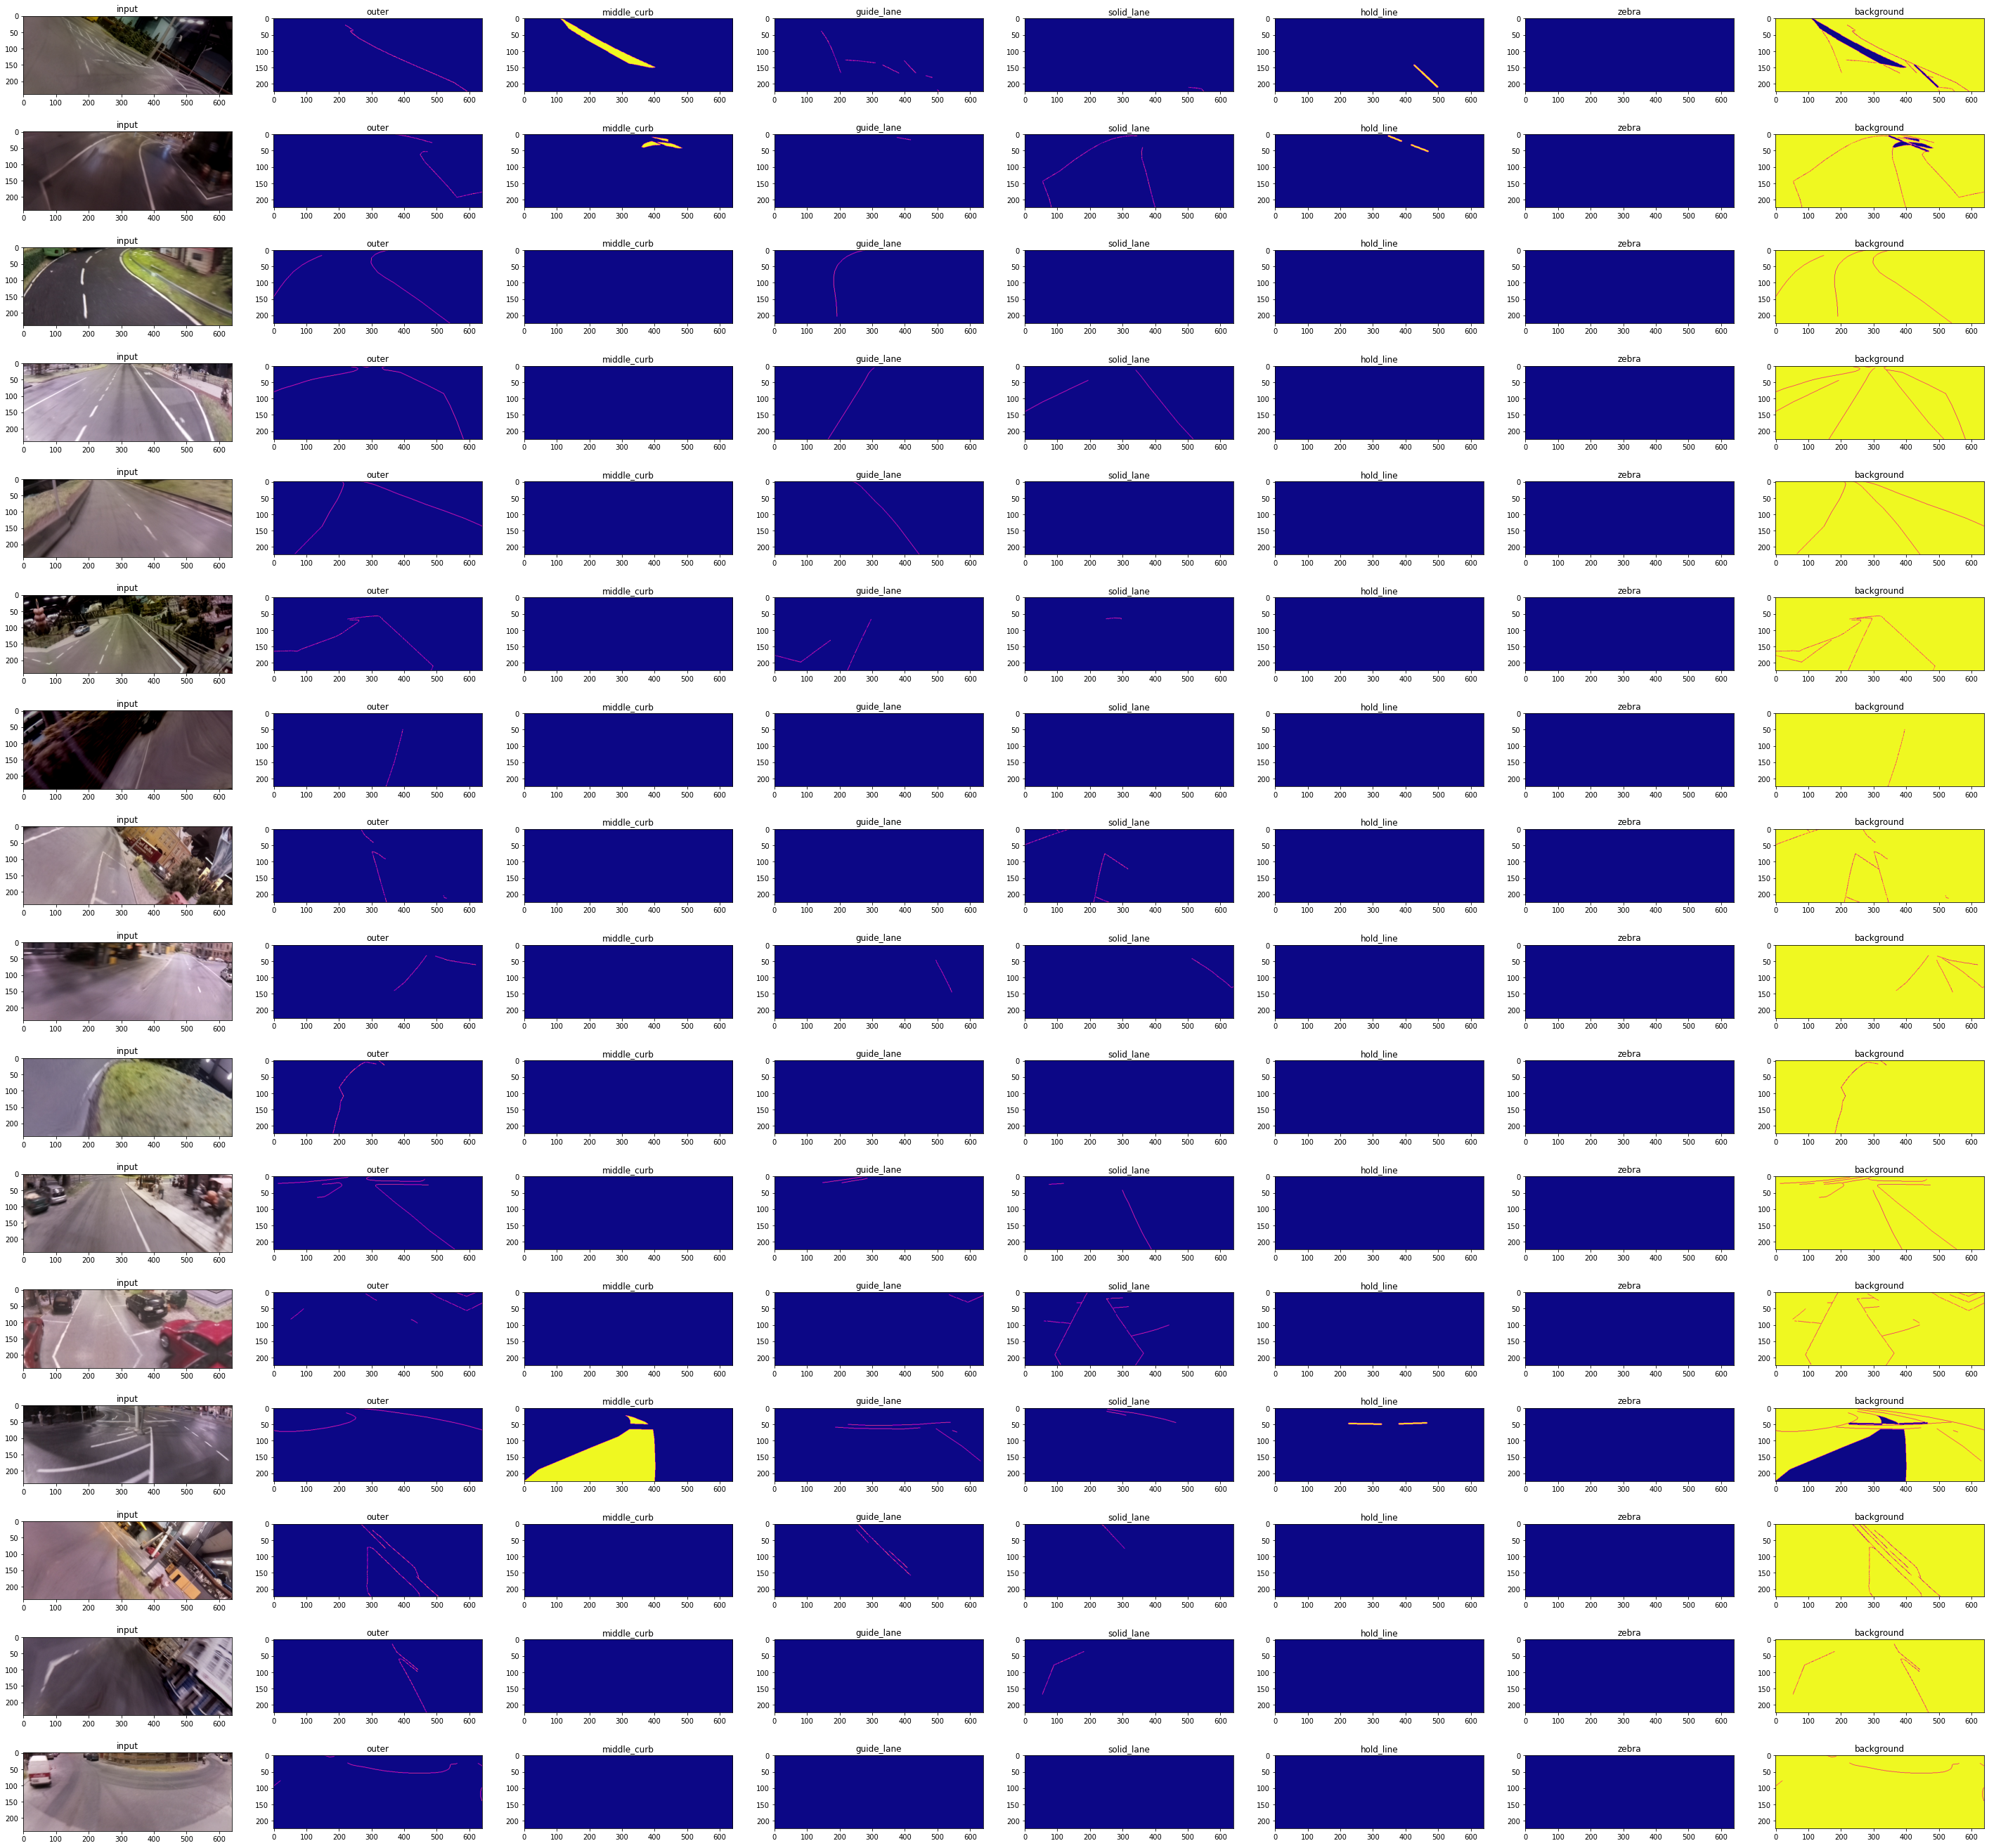

In [24]:
c = 16
f, axs = plt.subplots(c, 8, figsize=(50,c*3))
i = 0

batch_input_test = train_input_img_paths[:c]
batch_target_test = train_target_ann_paths[:c]
images, data = train_gen.data_generation(batch_input_test, batch_target_test)

print(len(images))
for y in range(c):
    axs[y,0].imshow(images[i])
    axs[y,0].title.set_text('input')
    axs[y,1].imshow(data[i][:,:,0], cmap='plasma')
    axs[y,1].title.set_text('outer')
    axs[y,2].imshow(data[i][:,:,1], cmap='plasma')
    axs[y,2].title.set_text('middle_curb')
    axs[y,3].imshow(data[i][:,:,2], cmap='plasma')
    axs[y,3].title.set_text('guide_lane')
    axs[y,4].imshow(data[i][:,:,3], cmap='plasma')
    axs[y,4].title.set_text('solid_lane')
    axs[y,5].imshow(data[i][:,:,4], cmap='plasma')
    axs[y,5].title.set_text('hold_line')
    axs[y,6].imshow(data[i][:,:,5], cmap='plasma')
    axs[y,6].title.set_text('zebra')
    axs[y,7].imshow(data[i][:,:,6], cmap='plasma')
    axs[y,7].title.set_text('background')
    i += 1

In [13]:
import models_backbone as models_b

model = models_b.reference('LANESEGMENTATION_REFERENCE', input_height, input_width, number_classes)
#model = custom_unet()
#model = segmentation_model()

print(model.summary())

Model: "LANESEGMENTATION_REFERENCE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 

In [14]:
# checkpoint
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.compat.v1.Session(config=config)
    
filepath="./model/ld_autosys_checkpoint.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

tf.get_logger().setLevel('ERROR')

history = model.fit(train_gen,
            validation_data=val_gen,
            epochs=epochs,
            use_multiprocessing=False,
            workers=6,
            callbacks=callbacks_list)
model.save(model_path)

2021-09-30 16:46:58.994576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 16:46:58.994829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 16:46:58.995043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 16:46:58.995422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 16:46:58.995624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/5
76/76 [==============================] - 32s 401ms/step - loss: 0.4945 - iou_score: 0.1104 - val_loss: 0.1110 - val_iou_score: 0.1389

Epoch 00001: val_loss improved from inf to 0.11101, saving model to ld_autosys_checkpoint.h5
Epoch 2/5
76/76 [==============================] - 31s 397ms/step - loss: 0.1080 - iou_score: 0.1392 - val_loss: 0.1003 - val_iou_score: 0.1394

Epoch 00002: val_loss improved from 0.11101 to 0.10027, saving model to ld_autosys_checkpoint.h5
Epoch 3/5
76/76 [==============================] - 31s 400ms/step - loss: 0.1097 - iou_score: 0.1389 - val_loss: 0.1054 - val_iou_score: 0.1390

Epoch 00003: val_loss did not improve from 0.10027
Epoch 4/5
76/76 [==============================] - 32s 398ms/step - loss: 0.1082 - iou_score: 0.1390 - val_loss: 0.1057 - val_iou_score: 0.1392

Epoch 00004: val_loss did not improve from 0.10027
Epoch 5/5
76/76 [==============================] - 32s 399ms/step - loss: 0.1081 - iou_score: 0.1391 - val_loss: 0.1035 - val_io

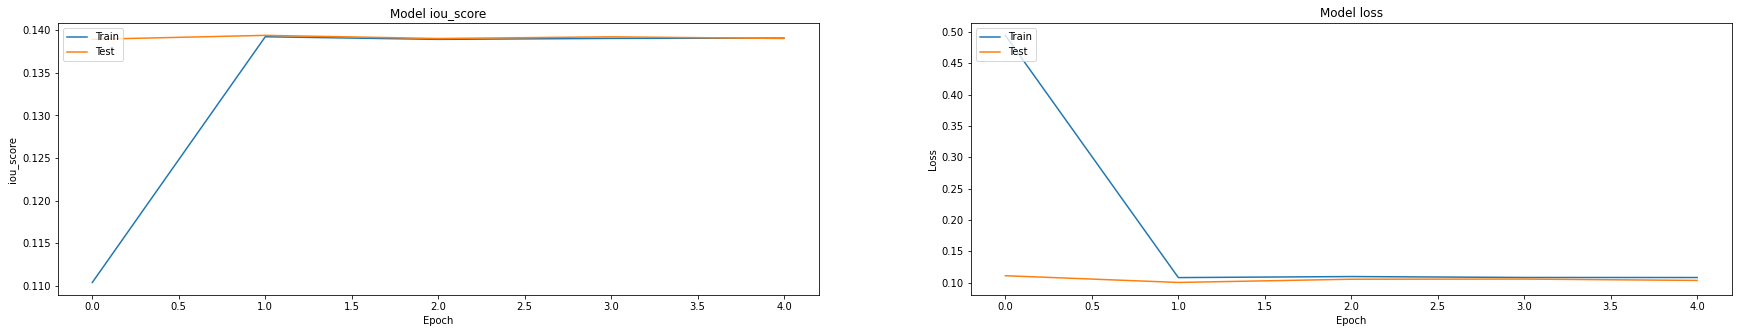

In [15]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('custom.png')
plt.show()



In [16]:
# load model only if not trained in this session\
model = load_model('./model/ld_autosys.h5', custom_objects={'iou_score':None})

In [17]:
# load some test images
cnt = 10

batch_input_test = train_input_img_paths[:cnt]
batch_target_test = train_target_ann_paths[:cnt]
images, data = train_gen.data_generation(batch_input_test, batch_target_test)

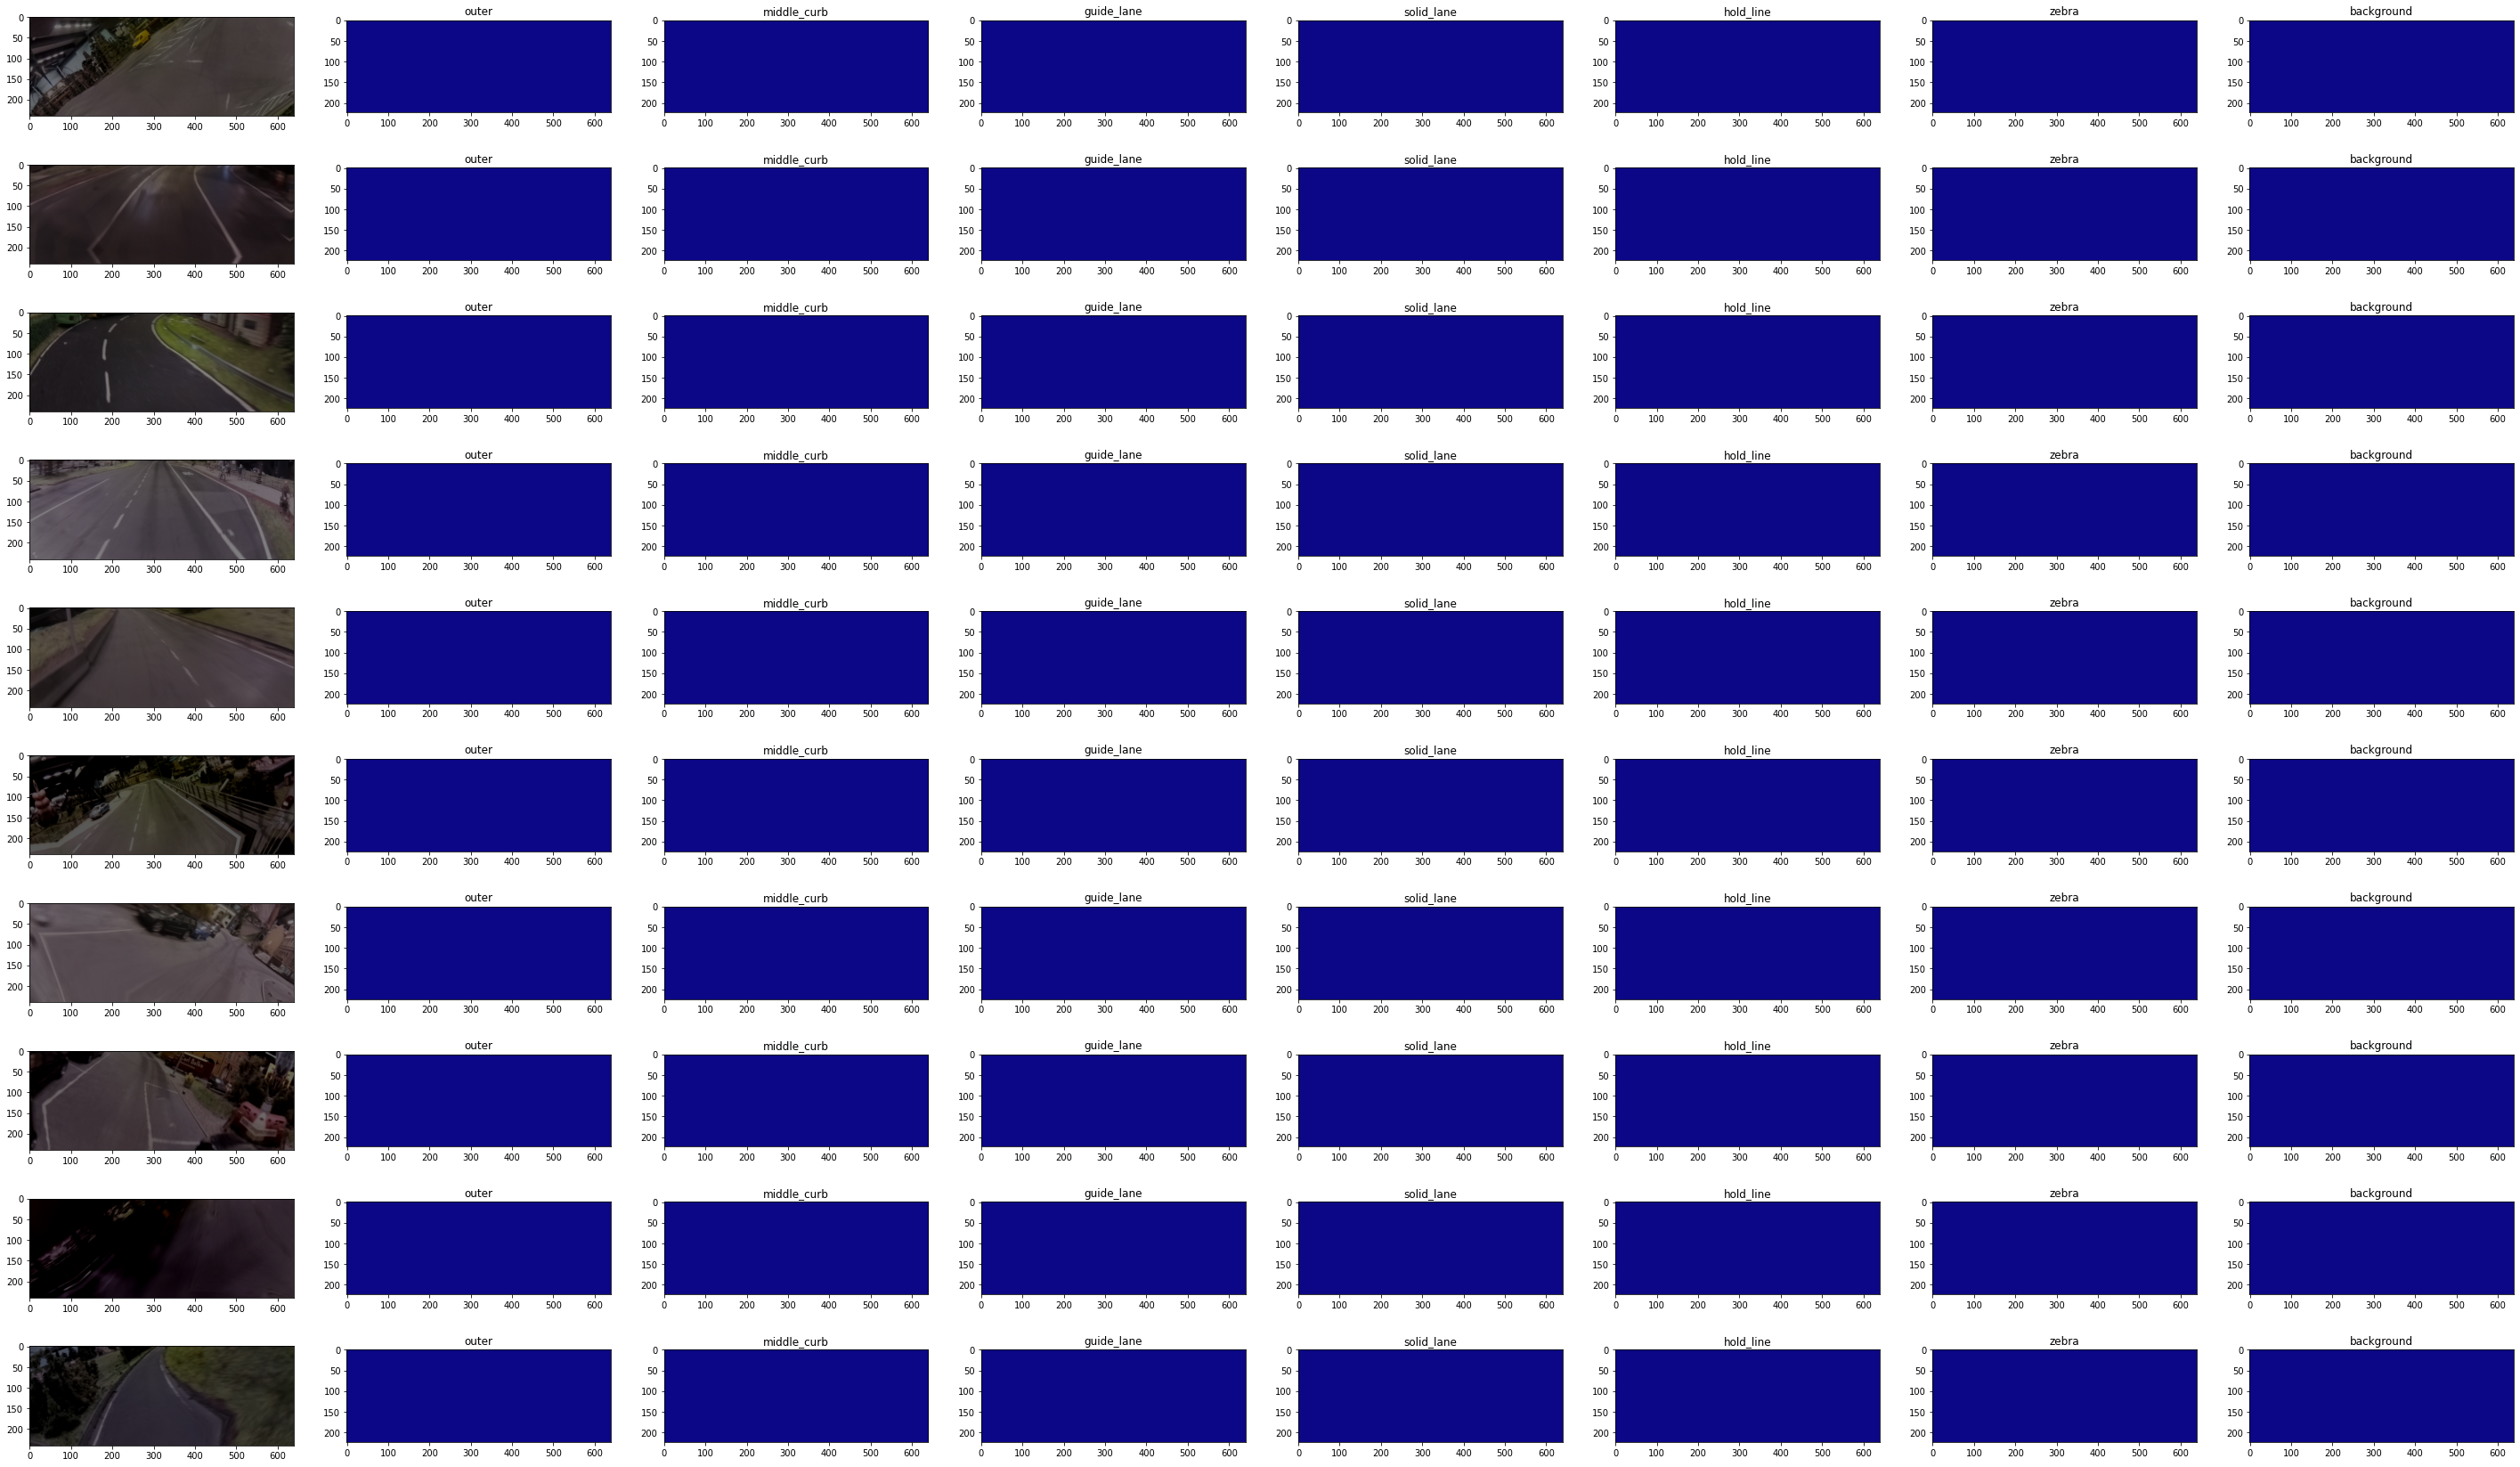

In [18]:
predictions = model.predict(np.array(images))[:cnt]

thres_value = 0.2

def postprocess_channel(img):
    #img = cv2.medianBlur(img, 3)
    _, img = cv2.threshold(img,thres_value,1.0,cv2.THRESH_BINARY)
    return img

f, axs = plt.subplots(len(predictions), 8, figsize=(50,len(predictions)*3))
for i, prediciton in enumerate(predictions):
    #test_img = cv2.resize(test_imgs[i], (x_values, y_values))
    test_img = images[i]
    test_img = test_img.astype(np.float32)
    predicted_lanes = np.sum([postprocess_channel(prediciton[:,:,i]) for i in range(6)], axis=0)
    predicted_lanes = cv2.merge([np.zeros_like(predicted_lanes), np.zeros_like(predicted_lanes), predicted_lanes])
    predicted_lanes = cv2.resize(predicted_lanes, (test_img.shape[1], test_img.shape[0]))
    overlay_image = cv2.addWeighted(test_img, 0.5, predicted_lanes, 0.5, 0)
    axs[i,0].imshow(overlay_image)
    #axs[i,0].imshow(test_imgs[i])

    axs[i,1].imshow(postprocess_channel(prediciton[:,:,0]), cmap='plasma')
    axs[i,1].title.set_text('outer')
    axs[i,2].imshow(postprocess_channel(prediciton[:,:,1]), cmap='plasma')
    axs[i,2].title.set_text('middle_curb')
    axs[i,3].imshow(postprocess_channel(prediciton[:,:,2]), cmap='plasma')
    axs[i,3].title.set_text('guide_lane')
    axs[i,4].imshow(postprocess_channel(prediciton[:,:,3]), cmap='plasma')
    axs[i,4].title.set_text('solid_lane')
    axs[i,5].imshow(postprocess_channel(prediciton[:,:,4]), cmap='plasma')
    axs[i,5].title.set_text('hold_line')
    axs[i,6].imshow(postprocess_channel(prediciton[:,:,5]), cmap='plasma')
    axs[i,6].title.set_text('zebra')
    axs[i,7].imshow(postprocess_channel(prediciton[:,:,6]), cmap='plasma')
    axs[i,7].title.set_text('background')